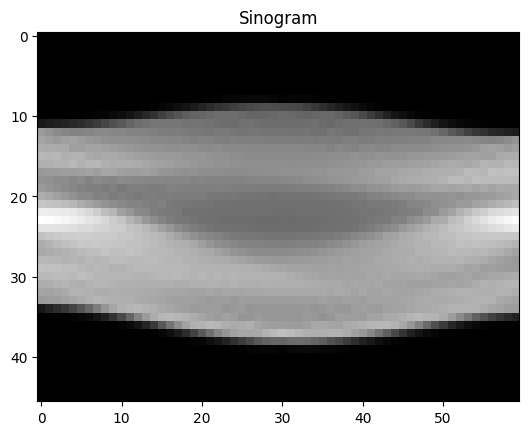

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon, iradon
from skimage.data import shepp_logan_phantom
from skimage.transform import resize
n = 32

circle = False
n_angles = 60
theta = np.linspace(0., 180.,n_angles, endpoint=False)
sigma = 100e-1
size = (radon(np.zeros((n,n)), theta=theta, circle = circle)).shape
M = size[0]*size[1]
A = np.zeros((M, n**2))
for i in range(n**2):
    e = np.zeros((n**2,))
    e[i]=1
    e = np.reshape(e,(n,n))
    sinogram = radon(e, theta=theta, circle = circle)
    A[:,i] = np.reshape(sinogram[:], (M,))

# Load the Shepp-Logan phantom
phantom = resize(shepp_logan_phantom(), (n,n))

#ground truth
x = phantom.reshape(-1)

#b
y = np.reshape(A@x, (int(np.ceil(n*np.sqrt(2))), n_angles))
plt.title("Sinogram")
plt.imshow(y, cmap='gray')

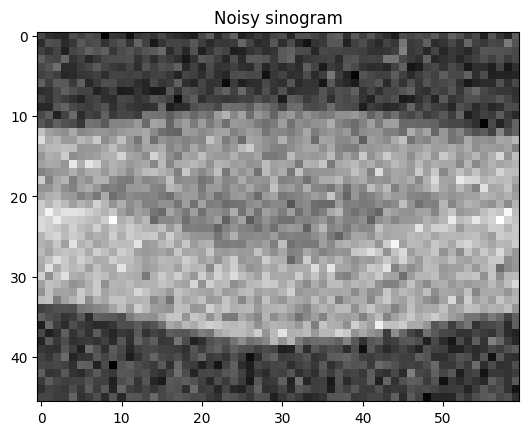

In [23]:
x_ground_truth = x.flatten()
clean_sinogram_flattened = A@x.flatten()
clean_sinogram_flattened.shape
#b = y + 0.5*np.random.standard_normal(y.shape)
b = clean_sinogram_flattened + np.random.normal(0,1,2760)
b.shape

#noisy sinogram
plt.title("Noisy sinogram")
s = np.reshape(b, (int(np.ceil(n*np.sqrt(2))), n_angles))
plt.imshow(s, cmap='gray')

Text(0.5, 1.0, 'FBP reconstruction')

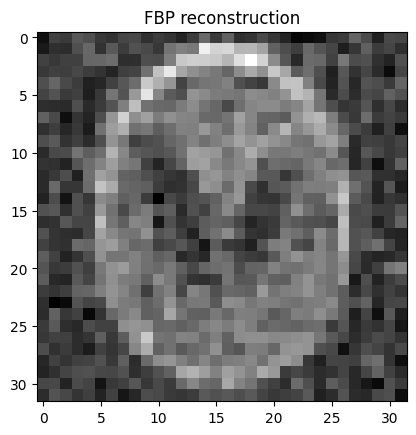

In [24]:
reconstruction_fbp = iradon(s, theta=theta, filter_name='ramp', circle=False)
plt.imshow(reconstruction_fbp, cmap='gray')
plt.title('FBP reconstruction')

In [63]:
import deepinv as dinv
import torch
from deepinv.models import DnCNN, DRUNet
from deepinv.optim.data_fidelity import L2
from deepinv.optim.prior import PnP
from deepinv.optim.optimizers import optim_builder
from deepinv.utils.demo import load_url_image, get_image_url
from deepinv.utils.plotting import plot, plot_curves

torch.manual_seed(0)
method = "PnP"
img_size = n


url = get_image_url("SheppLogan.png")
img = load_url_image(
    url=url, img_size=img_size, grayscale=True, resize_mode="resize", device="cpu"
)


pi = 4 * torch.ones(1).atan()
scaling = pi / (2 * 100)
noise = 0.1
# Forward model (Radon transform with Gaussian noise)
radon = dinv.physics.Tomography(img_width = n,
                                angles = 100,
                                cricle = False,
                                device = "cpu",
                                noise_model = dinv.physics.GaussianNoise(sigma = noise),
)



In [83]:
params = {"stepsize": 0.01 * scaling, "g_param": noise}
max_iter = 50
channels = 1 #3 for RGB, 1 for greyscale
forward = L2()

# DnCNN Zhang 2017 denoiser
dncnn = DnCNN(
    in_channels=channels,
    out_channels=channels,
    pretrained="download",  
    device="cpu",
)

# Zhang 2021 denoiser
drunet = DRUNet(
    in_channels= channels,
    out_channels= channels,
    pretrained="download",
    device="cpu",
)

# Classical priors
tvprior = dinv.optim.prior.TVPrior(n_it_max = max_iter)
bm3dprior = dinv.models.BM3D()




# Prior definition (TV, BM3D, DnCNN, DRUNet)

In [103]:
tvprior = dinv.optim.prior.TVPrior(n_it_max = max_iter)
#prior = PnP(denoiser = bm3dprior)
prior = PnP(denoiser = dncnn)
prior = PnP(denoiser = drunet)


In [104]:
# Create the model with proximal gradient descent, deep prior, radon forward model and all the setup required
model = optim_builder(
    iteration="PGD",
    prior= prior,
    data_fidelity = forward,
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo=params,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y) * scaling, radon.A_adjoint(y) * scaling)
    },
)

In [76]:
x =x.reshape(1, 1, 32, 32)
print(img.shape)

torch.Size([1, 1, 32, 32])


In [105]:
y = radon(x.float())
#y = radon(img)

fbp = radon.A_adjoint(y) * scaling

x_model, metrics = model(y, radon, x_gt = x, compute_metrics = True)

In [60]:
"""
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})
"""

def plot_psnrs_residuals(lists, method, color='blue'):
    """
    Peak-signal-to-noise ratio (PSNR) and residual plots vs iterations for a prior denoiser
    """

    psnrs = list(lists.values())[0]
    residuals = list(lists.values())[1]
    psnrs = np.array(psnrs).flatten()
    residuals = np.array(residuals).flatten()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5.5), constrained_layout = True)
    ax1.plot(range(1, len(psnrs) + 1), psnrs, marker = 'o', markersize = 1)
    ax1.set_ylabel('PSNR')
    ax1.set_xlabel('number of iterations: k')
    #axs[0].legend()
    ax1.grid()

    ax2.semilogy(residuals, marker = 'o', markersize = 1.2)
    ax2.set_ylabel('residual')
    ax2.set_xlabel('number of iterations: k')
    #axs[1].legend()
    ax2.grid()




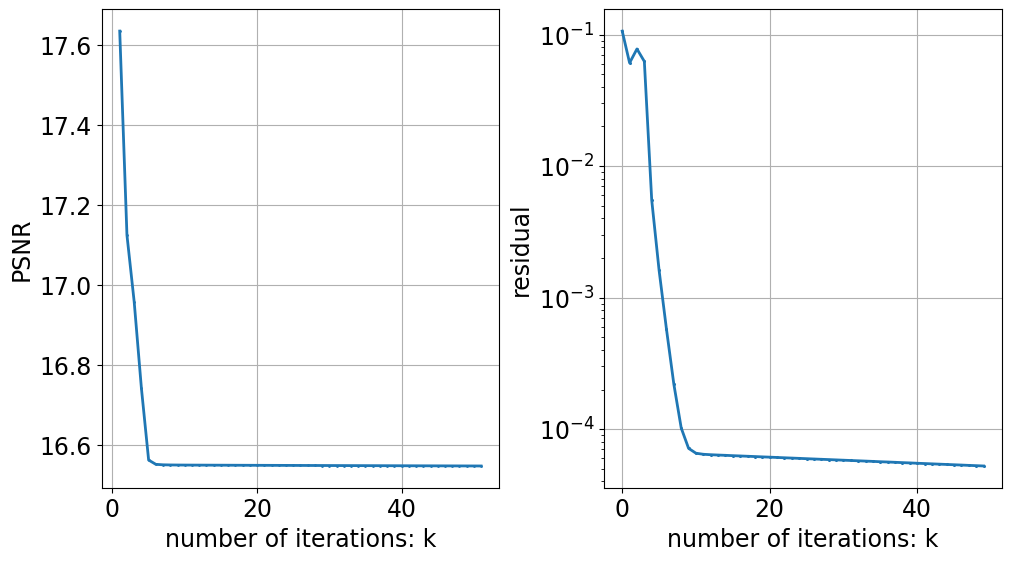

In [106]:
plot_psnrs_residuals(metrics, 'DRUNet')

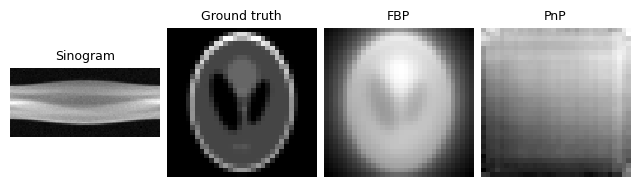

In [107]:
imgs = [y, img, fbp, x_model]
plot(imgs, titles = ["Sinogram", "Ground truth", "FBP", "PnP"])